In [ ]:
# https://medium.com/@ideami

In [ ]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def show(tensor, num=25, wandbactive=0, name=''):  # wandb = weights and biases (it is an online tool to track model training)
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  if wandbactive == 1 and wandbact == 1: # this part is optional
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})

  plt.imshow(grid.clip(0,1))
  plt.show()

### hyperparameters and general parameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device = 'cuda'

cur_step = 0
crit_cycle = 5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35

wandbact = 0 # if 1, we want to track stats through wieghts and biases (optional)

In [ ]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 140 kB 48.2 MB/s 
     |████████████████████████████████| 97 kB 6.9 MB/s 
     |████████████████████████████████| 180 kB 48.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [ ]:
# wandb.login(key='') # burda key e siteden aldığın API daki key i vermemiz gerekiyor ama ben yapmıcam

In [ ]:
### generator model
class Generator(nn.Module):
  
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(
        # we beign with 1x1 image with z_dim number of channels
        # calculating new width and height = (n-1)*stride - 2*padding + ks
        # n = width or height
        nn.ConvTranspose2d(z_dim, d_dim*32, 4, 1, 0),  # 4 x 4 (channels:200 --> 512)
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1),  # 8 x 8 (channels:512 --> 256)
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1),  # 16 x 16 (channels:256 --> 128)
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1),  # 32 x 32 (channels:128 --> 64)
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1),  # 64 x 64 (channels:64 --> 32)
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1),  # 128 x 128 (channels:32 --> 3)
        nn.Tanh()
    )
  
  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1)  # 128, 200, 1, 1 ---> batch_size, num_channels, width, height
    return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
  return torch.randn(num, z_dim, device=device)

In [ ]:
### Critic
class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()
    self.crit = nn.Sequential(
        nn.Conv2d(3, d_dim, 4, 2, 1),  # 128x128 ---> 64x64 (ch:3 ---> 16)
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim*2, 4, 2, 1),  # 64x64 ---> 32x32 (ch:16 ---> 32)
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1),  # 32x32 ---> 16x16 (ch:32 ---> 64)
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1),  # 16x16 ---> 8x8 (ch:64 ---> 128)
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1),  # 8x8 ---> 4x4 (ch:128 ---> 256)
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*16, 1, 4, 1, 0),  # 4x4 ---> 1x1 (ch:256 ---> 1)
    )

  def forward(self, image):
    # image: 128 x 3 x 128 x 128 --> batch_size, channels, width, height
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred),-1) # 128 x 1

In [ ]:
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

# Importing the dataset

In [ ]:
import gdown, zipfile

In [ ]:
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'

In [ ]:
path = 'data/celeba/'
download_path = path + 'img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

gdown.download(url,download_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:11<00:00, 127MB/s]


'data/celeba/img_align_celeba.zip'

In [ ]:
with zipfile.ZipFile(download_path, 'r') as zip:
  zip.extractall(path)

In [ ]:
class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    self.sizes = [size,size]
    items, labels = [], []

    for data in os.listdir(path)[:lim]:
      # path: './data/celeba/img_align_celeba'
      # data: '114568.jpg'
      item = os.path.join(path, data)
      items.append(item)
      labels.append(data)

    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB')  # (178,218) can be different
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # reshape to size we want: 128 x 128 x 3  
    data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False) # 3 x 128 x 128
    data = torch.from_numpy(data).div(255)
    return data, self.labels[idx]

In [ ]:
data_path = './data/celeba/img_align_celeba'
ds = Dataset(data_path, size=128, lim=10000)

In [ ]:
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [ ]:
### Generator
gen = Generator(z_dim).to(device)

### Critic
crit = Critic().to(device)

In [ ]:
### optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))

crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

In [ ]:
### weight initializations

# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

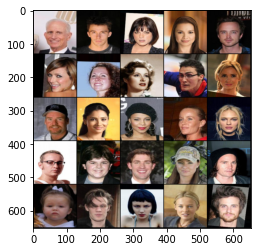

In [ ]:
x, y = next(iter(dataloader))
show(x)

In [ ]:
def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1) # 128 x 49152

  gradient_norm = gradient.norm(2, dim=1)

  gp = gamma * ((gradient_norm - 1) ** 2).mean()

  return gp

In [ ]:
root_path = './data/'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f'{root_path}G-{name}.pkl')

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f'{root_path}C-{name}.pkl')
  print('Checkpoint has been saved.')

def load_checkpoint(name):
  checkpoint = torch.load(f'{root_path}G-{name}.pkl')
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f'{root_path}C-{name}.pkl')
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print('Checkpoint has been loaded.')

In [ ]:
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs = len(real) # 128
    real = real.to(device)

    ### CRITIC
    mean_crit_loss = 0
    for _ in range(crit_cycle):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs, z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real),1,1,1,device=device,requires_grad=True)
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss += crit_loss.item() / crit_cycle

      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses += [mean_crit_loss]

    ### GENERATOR
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]

    ### STATS
    if wandbact==1:
      wandb.log({'Epoch':epoch, 'Step':cur_step, 'Critic loss':mean_crit_loss, 'Gen loss':gen_loss})

    if cur_step % save_step == 0 and cur_step > 0:
      print('Saving checkpoint...', cur_step, save_step)
      save_checkpoint('latest')

    if cur_step % show_step == 0 and cur_step > 0:
      show(fake, name='fake')
      show(real, name='real')

      gen_mean = sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f'Epoch: {epoch}: Step {cur_step}: Gen loss: {gen_mean}, Critic loss: {crit_mean}')

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label = 'Generator Loss'
          )
      
      plt.plot(
          range(len(gen_losses)),  # same
          torch.Tensor(crit_losses),
          label = 'Critic Loss'
          )
      
      plt.ylim(-1000, 1000)
      plt.legend()
      plt.show()

    cur_step += 1